In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys, glob

In [3]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

import matplotlib.dates as mdates

In [4]:
from datetime import datetime

### Required for google colab

### Setup

In [5]:
DATA_DIR = "../data-ita/dati-regioni"
# DATA_DIR = "../data-ita/dati-province"

## Data loading

In [6]:
csv_files = glob.glob(DATA_DIR + "/*-2020*.csv")

In [7]:
def extract_date(file_name):
    
    # Sample file path:
    # '../data-ita/dati-regioni/dpc-covid19-ita-regioni-20200313.csv'
    
    # Remove file extension
    date_str = os.path.basename(file_name)[:-4]
    
    # Extract last 8 characters
    date_str = date_str[-8:]
    
    date = datetime.strptime(date_str, '%Y%m%d').date()
    
    return date

In [8]:
country_df = None

for csv_file in csv_files:
    
    df = pd.read_csv(csv_file)
    date = extract_date(csv_file)
    df['Date'] = date
    
    if country_df is None:
        country_df = df
    else:
        country_df = pd.concat((country_df, df), ignore_index=True)

In [9]:
np.unique(country_df['denominazione_regione'])

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)

In [10]:
country_df.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,Date
0,2020-04-11T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,315,54,369,1355,1724,89,106,190,206,2120,19441,NaN,NaN,2020-04-11
1,2020-04-11T17:00:00,ITA,17,Basilicata,40.639471,15.805148,60,12,72,209,281,2,4,14,17,312,4050,NaN,NaN,2020-04-11
2,2020-04-11T17:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,246,56,302,967,1269,-48,2,488,200,1957,22186,NaN,NaN,2020-04-11
3,2020-04-11T17:00:00,ITA,18,Calabria,38.905976,16.594402,169,15,184,608,792,6,14,57,66,915,17493,NaN,NaN,2020-04-11
4,2020-04-11T17:00:00,ITA,15,Campania,40.839566,14.250850,582,85,667,2335,3002,39,75,277,238,3517,33781,NaN,NaN,2020-04-11


In [11]:
def get_region_data(country_df, region_name):
    region_df = country_df[country_df['denominazione_regione'] == region_name].sort_values(by="Date").copy()
    
    region_df['casi_su_tamponi'] = region_df['totale_casi']/region_df['tamponi']
    
    region_df['numero_nuovi_casi'] = region_df['totale_casi'].diff()
    region_df['numero_nuovi_tamponi'] = region_df['tamponi'].diff()
    
    region_df['casi_su_tamponi_daily'] = region_df['numero_nuovi_casi']/region_df['numero_nuovi_tamponi']
    
    return region_df    

In [12]:
regions_list = [
    'Puglia',
    'Calabria',
    'Sicilia',
    'Campania',
    'Calabria',
#     'Lombardia',
]

# provinces_list = [
# #     'Lodi',
#     'Napoli',
# #     'Bari',
# ]

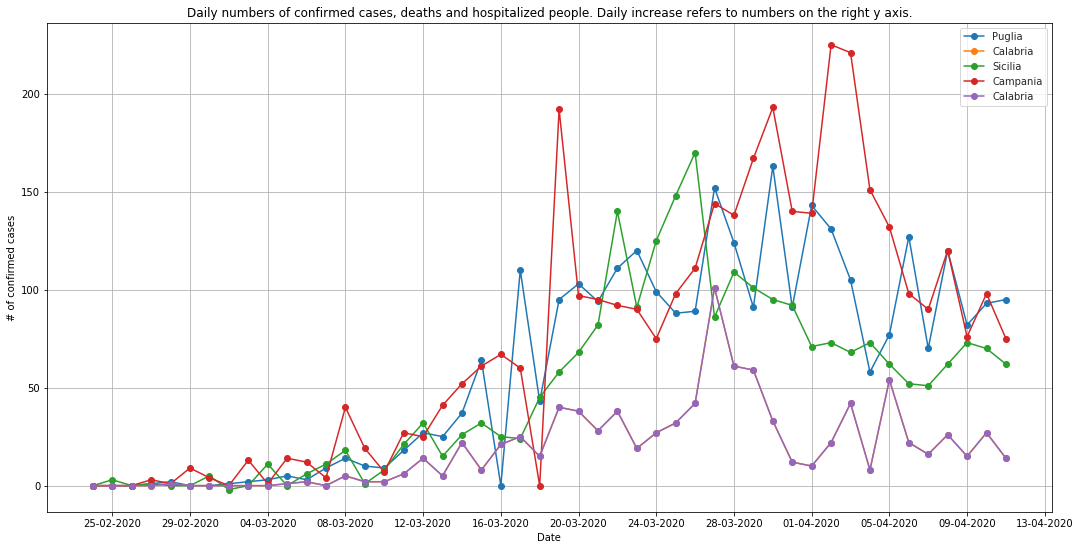

In [13]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

for region_name in regions_list:
#     region_df = country_df[country_df['denominazione_regione'] == region_name]
    region_df = get_region_data(country_df, region_name)
    region_df.plot(x='Date', y=["nuovi_positivi"], figsize=(18,9), ax=ax, marker='o')
    
    
# region_df = country_df[country_df['denominazione_regione'] == 'Lombardia']
# region_df.plot(x='Date', y=["nuovi_attualmente_positivi"], figsize=(18,9), ax=ax, marker='o', secondary_y=True)
    
# for province_name in provinces_list:
#     province_df = country_df[country_df['denominazione_provincia'] == province_name]
#     province_df.plot(x='Date', y=["totale_casi"], figsize=(18,9), ax=ax, marker='o')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylabel("# of confirmed cases");

ax.set_title("Daily numbers of confirmed cases, deaths and hospitalized people. Daily increase refers to numbers on the right y axis.");

# ax.legend(provinces_list)
# ax.legend(regions_list+['Lombardia'])
ax.legend(regions_list)

# plt.savefig("regions_daily_data.png");

The 10 regions with the higher number of confirmed cases

In [14]:
country_df.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,Date
1003,2020-03-30T17:00:00,ITA,9,Toscana,43.769231,11.255889,1116,279,1395,2655,4050,264,290,131,231,4412,30099,NaN,NaN,2020-03-30
1004,2020-03-30T17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,353,78,431,926,1357,64,88,178,147,1682,6377,NaN,NaN,2020-03-30
1005,2020-03-30T17:00:00,ITA,10,Umbria,43.106758,12.388247,173,47,220,614,834,-63,28,184,33,1051,8150,NaN,NaN,2020-03-30
1006,2020-03-30T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,92,26,118,400,518,-21,0,16,50,584,1536,NaN,NaN,2020-03-30
1007,2020-03-30T17:00:00,ITA,5,Veneto,45.434905,12.338452,1633,356,1989,5575,7564,313,366,747,413,8724,99941,NaN,NaN,2020-03-30


In [15]:
latest_date = country_df['Date'].max()

top10_hit_regions = country_df[country_df['Date'] == latest_date] \
    .sort_values(by='totale_casi', ascending=False) \
    .head(10)['denominazione_regione']

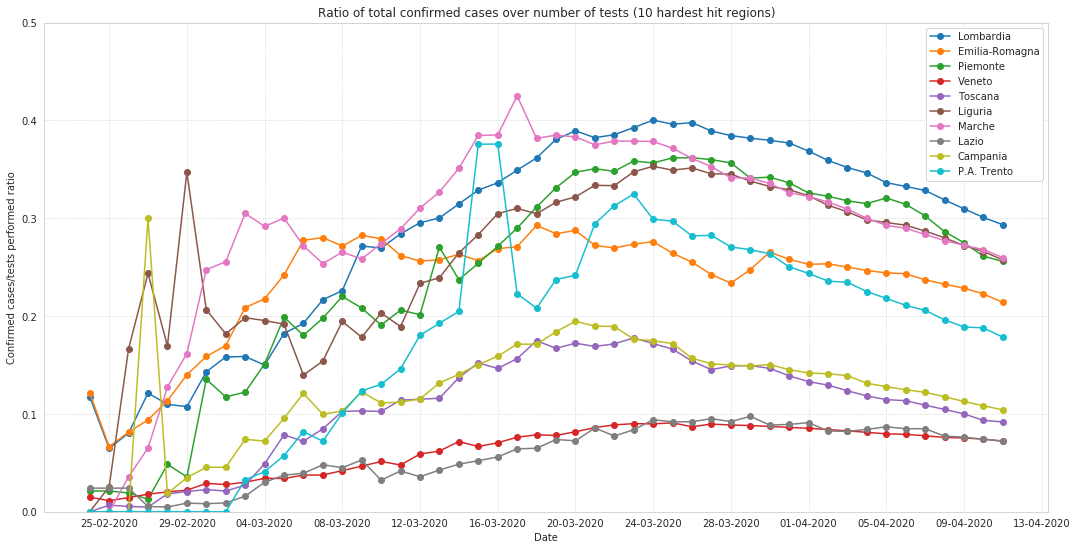

In [16]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

for region_name in top10_hit_regions:
#     region_df = country_df[country_df['denominazione_regione'] == region_name]
    region_df = get_region_data(country_df, region_name)
    region_df.plot(x='Date', y=["casi_su_tamponi"], figsize=(18,9), ax=ax, marker='o')
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylabel("Confirmed cases/tests performed ratio");

ax.set_title("Ratio of total confirmed cases over number of tests (10 hardest hit regions)");

ax.set_ylim([0, 0.5])

ax.legend(top10_hit_regions);

plt.savefig("cases_over_tests_ratio_italy.png");

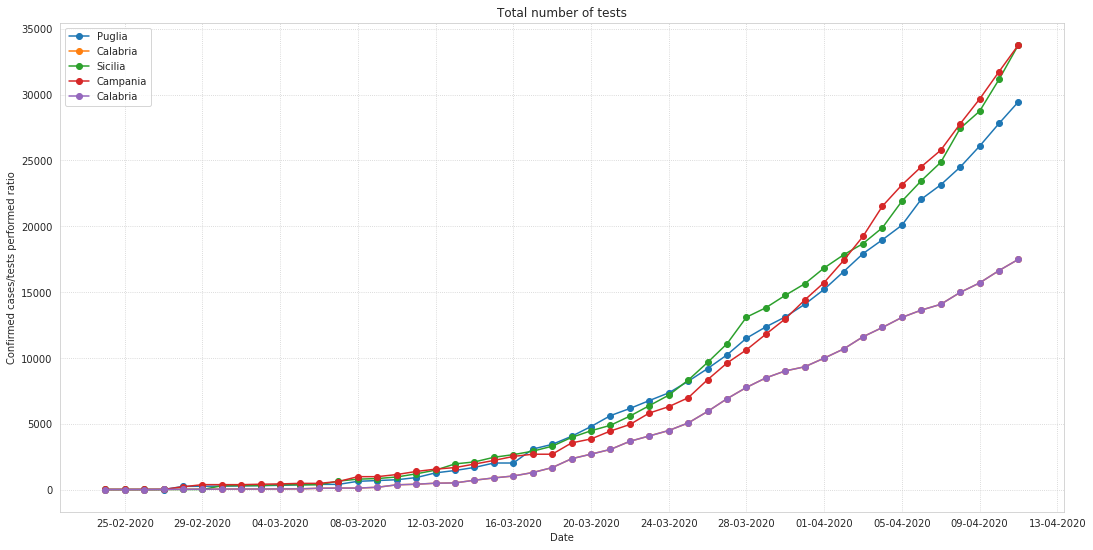

In [17]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

for region_name in regions_list:
#     region_df = country_df[country_df['denominazione_regione'] == region_name]
    region_df = get_region_data(country_df, region_name)
    region_df.plot(x='Date', y=["tamponi"], figsize=(18,9), ax=ax, marker='o')
    
    
# region_df = country_df[country_df['denominazione_regione'] == 'Lombardia']
# region_df.plot(x='Date', y=["nuovi_attualmente_positivi"], figsize=(18,9), ax=ax, marker='o', secondary_y=True)
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylabel("Confirmed cases/tests performed ratio");

ax.set_title("Total number of tests");

ax.legend(regions_list);


# plt.savefig("regions_daily_data.png");